In [1]:
%%time
from windwhisper import WindTurbines, NoisePropagation, NoiseAnalysis, HumanHealth
import xarray as xr

# we can preload the wind speed data, otherwise, the tool will do it every time
filepath_wind_speed = "/Users/romain/GitHub/windwhisper/dev/fixtures/era5_mean_2013-2022_month_by_hour.nc"
filepath_correction = "/Users/romain/GitHub/windwhisper/dev/fixtures/ratio_gwa2_era5.nc"

def wind_speed_data():

    wind_speed = xr.open_dataset(filepath_wind_speed).to_array().mean(dim="month")
    correction = xr.open_dataset(filepath_correction).to_array()
    correction = correction.sel(variable='ratio_gwa2_era5_mean_WS').interp(latitude=wind_speed.latitude, longitude=wind_speed.longitude, method="linear")
    return wind_speed * correction

wind_speed_data = wind_speed_data()

# note: make ensure latitude and longitude coordinates are sorted in ascending order
elevation_data = xr.open_dataset("fixtures/elevation_europe.nc")


CPU times: user 4.56 s, sys: 2.8 s, total: 7.36 s
Wall time: 8.82 s


In [2]:
%%time
wind_turbines = {
    'Turbine 0':
     {
        'diameter': 70.0,
        'hub height': 85.0,
        'position': (43.45111343125036, 5.2518247370645215),
        'power': 2500.0
     },
}

wt = WindTurbines(
    wind_turbines=wind_turbines,
    wind_speed_data=wind_speed_data,
    #retrain_model=True
)

/opt/homebrew/Caskroom/miniforge/base/envs/windwhisper/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator HistGradientBoostingRegressor from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/windwhisper/lib/python3.11/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator _BinMapper from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/windwhisper/lib/python3.11/site-packages/sklearn/base.py:440: Inconsiste

CPU times: user 417 ms, sys: 242 ms, total: 659 ms
Wall time: 562 ms


In [3]:
noise_prop = NoisePropagation(
    wind_turbines=wt.wind_turbines,
    humidity=70,
    temperature=20,
    elevation_data=elevation_data,
)

Using local elevation data


In [4]:
noise_analysis = NoiseAnalysis(
    noise_propagation=noise_prop,
    wind_turbines=wt.wind_turbines,
)

In [5]:
hh = HumanHealth(
    noise_analysis
)

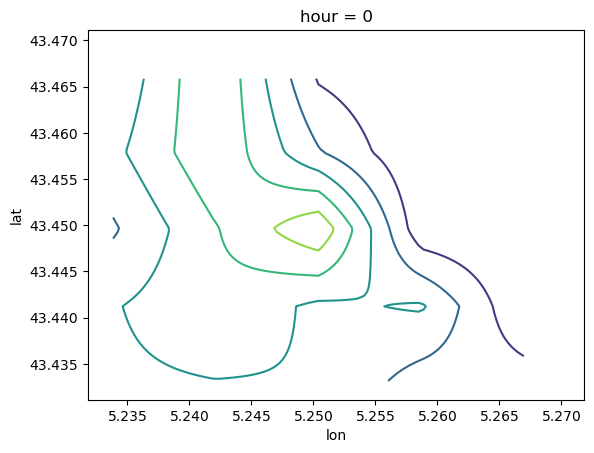

In [8]:
hh.population.plot.contour()

In [7]:
hh.population.sum()

<xarray.DataArray 'population' ()> Size: 4B
array(16405.113, dtype=float32)
Coordinates:
    hour     int64 8B 0

In [6]:
hh.electricity_production

122079544.22235489

In [7]:
hh.electricity_production/(2500*1*1*8760*20)

0.2787204205989838

In [8]:
hh.export_to_excel("human health case.xlsx")

In [1]:
from windwhisper.electricity_production import get_capacity_factor

In [2]:
get_capacity_factor(
    43.4963381431904, 5.603112659991827
)

0.27013158798217773

In [9]:
arr = xr.open_dataset("ghs_pop_europe.nc")

In [10]:
arr

<xarray.Dataset> Size: 11GB
Dimensions:     (lat: 29616, lon: 96656)
Coordinates:
  * lat         (lat) float64 237kB 72.77 72.77 72.77 ... 33.07 33.06 33.06
  * lon         (lon) float64 773kB -44.09 -44.08 -44.08 ... 85.51 85.51 85.51
Data variables:
    population  (lat, lon) float32 11GB ...

In [ ]:
from pathlib import Path
import rasterio
from rasterio.merge import merge
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import xarray as xr
from tqdm import tqdm

def mosaic_and_save_population_tiles(input_dir, output_nc_path, variable_name="population", reproject_to_latlon=True, target_resolution=None):
    input_dir = Path(input_dir)
    files = sorted(input_dir.glob("*.tif"))

    print(f"📦 Found {len(files)} tiles.")

    # Open all datasets
    datasets = [rasterio.open(f) for f in files]

    # Merge tiles
    print("🔀 Merging tiles...")
    mosaic, out_trans = merge(datasets)
    out_meta = datasets[0].meta.copy()
    out_meta.update({
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans
    })

    # Reproject to lat/lon if required
    if reproject_to_latlon:
        dst_crs = "EPSG:4326"
        bounds = rasterio.transform.array_bounds(mosaic.shape[1], mosaic.shape[2], out_trans)
        transform, width, height = calculate_default_transform(
            datasets[0].crs, dst_crs, mosaic.shape[2], mosaic.shape[1], *bounds)
        kwargs = out_meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        reprojected = np.zeros((1, height, width), dtype=mosaic.dtype)

        reproject(
            source=mosaic,
            destination=reprojected,
            src_transform=out_trans,
            src_crs=datasets[0].crs,
            dst_transform=transform,
            dst_crs=dst_crs,
            resampling=Resampling.sum  # <- preserves total population
        )
        mosaic = reprojected
        out_meta = kwargs

    # Create coordinates
    transform = out_meta["transform"]
    height, width = mosaic.shape[1:]
    lon = np.array([transform * (i, 0) for i in range(width)])[:, 0]
    lat = np.array([transform * (0, j) for j in range(height)])[:, 1]

    # Downsample using sum to preserve total population
    original_resolution = abs(transform.a)
    
    if target_resolution is None:
        scale = 1
    else:
        scale = target_resolution / original_resolution

    if scale == 1:
        downsampled = mosaic
        lat_down = lat
        lon_down = lon
    elif scale > 1.0:
        print(f"📉 Downsampling with scale={scale:.2f} (target resolution = {target_resolution} m)")
        new_h = int(mosaic.shape[1] // scale)
        new_w = int(mosaic.shape[2] // scale)
        reshaped = mosaic[:, :new_h * int(scale), :new_w * int(scale)].reshape(1, new_h, int(scale), new_w, int(scale))
        downsampled = reshaped.sum(axis=(2, 4))
        lat_down = np.linspace(lat.min(), lat.max(), downsampled.shape[1])
        lon_down = np.linspace(lon.min(), lon.max(), downsampled.shape[2])
    else:
        print(f"⚠️ Cannot upscale (scale={scale:.2f}). Skipping resampling.")
        downsampled = mosaic
        lat_down = lat
        lon_down = lon

    # Create xarray DataArray
    da = xr.DataArray(
        downsampled[0],
        dims=["lat", "lon"],
        coords={"lat": lat_down, "lon": lon_down},
        name=variable_name
    )

    print(f"🗘️ Final shape: {da.shape} | Resolution ~{abs(da.lat[1] - da.lat[0]):.5f}°")

    # Save to NetCDF
    encoding = {variable_name: {"dtype": "float32", "zlib": True, "complevel": 4}}
    da.to_netcdf(output_nc_path, encoding=encoding)
    print(f"✅ Saved to {output_nc_path}")


# Example usage:
mosaic_and_save_population_tiles(
    "/Users/romain/GitHub/windwhisper/dev/fixtures/POP",
    "ghs_pop_europe.nc",
    reproject_to_latlon=False,
    target_resolution=None
)

📦 Found 21 tiles.
🔀 Merging tiles...
🗘️ Final shape: (40000, 60000) | Resolution ~100.00000°


In [1]:
from pathlib import Path
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import os

def merge_tiles_to_tif(input_dir, output_tif_path):
    input_dir = Path(input_dir)
    files = sorted(input_dir.glob("*.tif"))

    if not files:
        raise ValueError("No .tif files found in the directory.")

    print(f"📦 Found {len(files)} tiles.")
    
    # Open all raster files
    src_files_to_mosaic = [rasterio.open(fp) for fp in files]

    # Merge them
    print("🔀 Merging tiles...")
    mosaic, out_trans = merge(src_files_to_mosaic)

    # Use metadata from the first file
    out_meta = src_files_to_mosaic[0].meta.copy()
    out_meta.update({
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans
    })

    # Write the mosaic to disk
    print(f"💾 Saving to {output_tif_path}")
    with rasterio.open(output_tif_path, "w", **out_meta) as dest:
        dest.write(mosaic)

    print("✅ Done.")

# Example usage
merge_tiles_to_tif(
    input_dir="/Users/romain/GitHub/windwhisper/dev/fixtures/POP",
    output_tif_path="ghs_pop_merged.tif"
)


📦 Found 21 tiles.
🔀 Merging tiles...
💾 Saving to ghs_pop_merged.tif
✅ Done.


In [1]:
import rasterio
import xarray as xr
import numpy as np
from pathlib import Path

def tif_to_netcdf(input_tif, output_nc, variable_name="population"):
    input_tif = Path(input_tif)
    output_nc = Path(output_nc)

    with rasterio.open(input_tif) as src:
        data = src.read(1)  # First band
        transform = src.transform
        crs = src.crs

        if crs.to_epsg() != 4326:
            raise ValueError("❌ The CRS is not WGS84 (EPSG:4326).")

        width, height = src.width, src.height

        # Construct lon/lat arrays
        lon = np.linspace(transform.c, transform.c + transform.a * width, width, endpoint=False)
        lat = np.linspace(transform.f, transform.f + transform.e * height, height, endpoint=False)

        # Flip latitude axis if needed
        if lat[0] < lat[-1]:
            lat = lat[::-1]
            data = data[::-1, :]

        da = xr.DataArray(
            data,
            dims=["lat", "lon"],
            coords={"lat": lat, "lon": lon},
            name=variable_name,
            attrs={"units": "people", "crs": "EPSG:4326"},
        )

    # Save to NetCDF
    encoding = {variable_name: {"dtype": "float32", "zlib": True, "complevel": 4}}
    da.to_netcdf(output_nc, encoding=encoding)

    print(f"✅ Saved to {output_nc} with shape {da.shape} and resolution ~{abs(lat[1] - lat[0]):.5f}°")

tif_to_netcdf("/Users/romain/GitHub/windwhisper/dev/fixtures/GHS_POP_E2020_GLOBE_R2023A_4326_30ss_V1_0/GHS_POP_E2020_GLOBE_R2023A_4326_30ss_V1_0.tif", "worldpop.nc")


✅ Saved to worldpop.nc with shape (21384, 43202) and resolution ~0.00833°


In [2]:
arr = xr.open_dataset("worldpop.nc")
arr.sum()

<xarray.Dataset> Size: 4B
Dimensions:     ()
Data variables:
    population  float32 4B 7.841e+09

In [3]:
arr

<xarray.Dataset> Size: 4GB
Dimensions:     (lat: 21384, lon: 43202)
Coordinates:
  * lat         (lat) float64 171kB 89.1 89.09 89.08 ... -89.08 -89.08 -89.09
  * lon         (lon) float64 346kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    population  (lat, lon) float32 4GB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0